In [11]:
import time
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from pathlib import Path
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, CustomJS, FixedTicker, LabelSet
from bokeh.layouts import column
output_notebook()

Loading BokehJS ...

In [12]:
ROOT = Path().resolve().parent

# load data
enrolments = pd.read_csv(ROOT / "converted-data" / "enrolments.csv")
exams = pd.read_csv(ROOT / "converted-data" / "exams.csv")
students = pd.read_csv(ROOT / "converted-data" / "students.csv")
coincidences = pd.read_csv(ROOT / "converted-data" / "coincidences.csv", index_col=0)
dates = pd.read_csv(ROOT / "converted-data" / "dates.csv")
times_expanded = pd.read_csv(ROOT / "converted-data" / "times_expanded.csv")
rooms = pd.read_csv(ROOT / "converted-data" / "rooms.csv")
earliness = pd.read_csv(ROOT / "converted-data" / "earliness.csv")

In [13]:
# Helper function: convert exam duration from hh:mm to minutes
def parse_duration(time_str):
    h, m = time_str.split(":")
    return int(h) * 60 + int(m)

# Converting hours to mins
exams["duration_minutes"] = exams["duration"].apply(parse_duration)
times_expanded["timeslot"] = range(1, len(times_expanded) + 1)
times_expanded["slot_minutes"] = times_expanded["duration_hours"] * 60

# exam_list (list): the list of every exam
exam_list = exams["exam"].unique().tolist()

# duration (dict): the mapping from exam -> duration (mins)
duration = exams.set_index("exam")["duration_minutes"].to_dict()

# timeslots (list): the list of every timeslot
timeslots = times_expanded["timeslot"].tolist()

# slot_length (dict): the mapping from timeslots -> timeslots length (mins)
slot_length = times_expanded.set_index("timeslot")["slot_minutes"].to_dict()

# timeslot_day (dict): the mapping from timeslots -> day it occurs, in the form day_week
timeslot_day = {
    int(row["timeslot"]): f"{row['day']}_{row['week']}"
    for _, row in times_expanded.iterrows()
}

# days (list): the list of exam day, in the form day_week
days = list(set(timeslot_day.values()))

# day_to_timeslots (dict): the mapping from days -> list of timeslots in that day (sorted)
day_to_timeslots = {}
for t, day in timeslot_day.items():
    day_to_timeslots.setdefault(day, []).append(t)
for d in day_to_timeslots:
    day_to_timeslots[d] = sorted(day_to_timeslots[d])

am_slots = [day_to_timeslots[d][0] for d in day_to_timeslots.keys()]


# students_exams (dict): the mapping from students -> list of exams to take
students_exams = enrolments.groupby("student")["exam"].apply(list).to_dict()

# room_list (list): the list of every available room
room_list = rooms["room"].tolist()

# cap (dict): the mapping from room_list -> capacity of that room
cap = rooms.set_index("room")["capacity"].to_dict()

# size (dict): the mapping from exams -> number of students in that exam
size = (
    enrolments.groupby("exam")["student"]
    .nunique()
    .sort_values(ascending=False)
    .to_dict()
)

# groups (dict): the mapping from index -> lists of coincidences exam
groups = {
    k: ast.literal_eval(v) for k, v in zip(coincidences.index, coincidences["exams"])
}

# allow_pairs (list): the list of list of coincidences pairs
allowed_pairs = [
    (e1, e2)
    for exam_list_g in groups.values()
    for i, e1 in enumerate(exam_list_g)
    for e2 in exam_list_g[i + 1 :]
    for _ in range(2)
][::-1][::2][::-1] + [
    (e2, e1)
    for exam_list_g in groups.values()
    for i, e1 in enumerate(exam_list_g)
    for e2 in exam_list_g[i + 1 :]
]

# together_groups (list): the list of list of merge-able rooms
together_groups = [
    ["POPE-A13", "POPE-A14"],
    ["ART-LECTURE", "ART-SEMINAR"],
    ["SPORT-LGE1", "SPORT-LGE2"],
]

# special_exams (list): the list of exams with special rooms
special_exams = ["F12X02E1", "K1AHWAE2", "V13101E1"]

# super_rooms (list): the list of index of super rooms
super_rooms = list(range(len(together_groups)))

# super_capacity (dict): the mapping from super rooms index -> its capacity
super_capacity = {g: sum(cap[r] for r in together_groups[g]) for g in super_rooms}

# super_to_rooms (dict): the mapping from super rooms index -> the list of rooms that merge into
super_to_rooms = {g: together_groups[g] for g in super_rooms}

# time_order (list): list of available timeslot per day
time_order = ["9:00", "13:30", "16:30"]

# max_capacity (const): maximum students per timeslot
max_capacity = 1550

# earliness_priority (dict): the mapping from exam lists -> its priority. Higher priority means earlier (if possible)
earliness_priority = (earliness.set_index("exam")["priority"].to_dict()| {e: 0 for e in exam_list if e not in earliness["exam"].values})

# time_to_y (dict): the mapping from time strings -> numeric Y values (for plotting)
time_to_y = {t: i + 1 for i, t in enumerate(time_order)}

# day_to_x (dict): the mapping from days -> numeric X values (for plotting)
day_to_x = {"Mon": 1, "Tue": 2, "Wed": 3, "Thu": 4, "Fri": 5, "Sat": 6}

am_slots

[1, 4, 7, 10, 13, 16, 17, 20, 23, 26, 29, 32]

In [21]:
def run_model(cap_multiplier=1.0, global_cap_multiplier=1.0, K=3, enrollment_multiplier=1.0, verbose=False):
    start = time.time()

    # SCALE ROOM CAPACITIES + ENROLLMENT
    cap_scaled = {r: int(cap[r] * cap_multiplier) for r in cap}
    size_scaled = {e: int(size[e] * enrollment_multiplier) for e in size}
    base_global_capacity = 1550
    global_capacity = int(base_global_capacity * global_cap_multiplier)

    # BUILD MODEL 5
    model = gp.Model("Model5_Sensitivity")
    model.setParam("OutputFlag", 0)
    model.setParam("TimeLimit", 600)    # 3 minutes

    # VARIABLES
    x = model.addVars(exam_list, timeslots, vtype=GRB.BINARY, name="x")
    cvar = model.addVars(groups.keys(), timeslots, vtype=GRB.BINARY, name="c")
    z = model.addVars(exam_list, timeslots, room_list, vtype=GRB.BINARY, name="z")
    p = model.addVars(exam_list, timeslots, room_list, vtype=GRB.INTEGER, lb=0, name="p")

    # CONSTRAINTS (same as Model 5)

    # 1. Each exam once
    for e in exam_list:
        model.addConstr(gp.quicksum(x[e,t] for t in timeslots) == 1)

    # 2. No conflict for students
    for s, exams_s in students_exams.items():
        for i in range(len(exams_s)):
            for j in range(i+1, len(exams_s)):
                e1, e2 = exams_s[i], exams_s[j]
                if (e1, e2) in allowed_pairs: 
                    continue
                for t in timeslots:
                    model.addConstr(x[e1,t] + x[e2,t] <= 1)

    # 3. Duration
    for e in exam_list:
        for t in timeslots:
            if duration[e] > slot_length[t]:
                model.addConstr(x[e,t] == 0)

    # 4. Link group
    for g, exams_g in groups.items():
        for e in exams_g:
            for t in timeslots:
                model.addConstr(x[e,t] <= cvar[g,t])

    # 5. Group once
    for g in groups:
        model.addConstr(gp.quicksum(cvar[g,t] for t in timeslots) == 1)

    # 6. Global timeslot capacity
    for t in timeslots:
        model.addConstr(
            gp.quicksum(size_scaled[e] * x[e,t] for e in exam_list) <= global_capacity
        )

    # 7. z <= x
    for e in exam_list:
        for t in timeslots:
            for r in room_list:
                model.addConstr(z[e,t,r] <= x[e,t])

    # 8. room capacity with scaled cap
    for e in exam_list:
        for t in timeslots:
            for r in room_list:
                model.addConstr(
                    p[e,t,r] <= cap_scaled[r] * z[e,t,r]
                )

    # 9. assign scaled sizes
    for e in exam_list:
        for t in timeslots:
            model.addConstr(
                gp.quicksum(p[e,t,r] for r in room_list) == size_scaled[e] * x[e,t]
            )

    # 10. max rooms K
    for e in exam_list:
        for t in timeslots:
            model.addConstr(
                gp.quicksum(z[e,t,r] for r in room_list) <= K
            )

    # 11–12 Gap rules
    for s, exams_s in students_exams.items():
        for d, t_list in day_to_timeslots.items():

            if len(t_list) == 3:
                first_slot, middle_slot, last_slot = t_list

                for i in range(len(exams_s)):
                    for j in range(i+1, len(exams_s)):
                        e1, e2 = exams_s[i], exams_s[j]
                        if (e1, e2) in allowed_pairs:
                            continue

                        model.addConstr(x[e1,middle_slot] + x[e2,first_slot] <= 1)
                        model.addConstr(x[e1,middle_slot] + x[e2,middle_slot] <= 1)
                        model.addConstr(x[e1,middle_slot] + x[e2,last_slot] <= 1)
                        model.addConstr(x[e1,first_slot] + x[e2,middle_slot] <= 1)
                        model.addConstr(x[e1,last_slot] + x[e2,middle_slot] <= 1)

    # ALL 17 SPECIAL MODEL 5 RULES
    # (Reuse your existing constraints exactly)

    # 12. fixed F321Q6E1
    model.addConstr(gp.quicksum(x["F321Q6E1",t] for t in day_to_timeslots["Fri_1"]) == 1)

    # 13.
    model.addConstr(gp.quicksum(x["F321T6E1",t] for t in day_to_timeslots["Mon_2"]) == 1)

    # 14–15–16 grouped
    for E in ["H21M01E1","H22M02E1","H2CM04E1"]:
        model.addConstr(
            gp.quicksum(x[E,t] for t in day_to_timeslots["Mon_1"] + day_to_timeslots["Tue_1"]) == 1
        )

    # 17 week1 only
    model.addConstr(gp.quicksum(x["G13RE2E1",t] for t in timeslots[:16]) == 1)

    # 18 AM-only
    model.addConstr(gp.quicksum(x["K1AHWAE2",t] for t in am_slots) == 1)
    model.addConstr(gp.quicksum(x["H63122E1",t] for t in am_slots) == 1)

    # 20 Thu PM only
    thursday_pm_slots = [11,12,27,28]
    model.addConstr(gp.quicksum(x["V13101E1",t] for t in thursday_pm_slots) == 1)

    # 21 room unavailable
    for e in exam_list:
        model.addConstr(z[e,29,"TRENT-B46"] == 0)

    # 22 precedence
    precedence_pairs = [
        ("F13P03E1","F13X03E1"),
        ("F13P03E1","F13X04E1"),
        ("F13P05E1","F13X03E1"),
        ("F13P05E1","F13X04E1")
    ]
    for e1,e2 in precedence_pairs:
        model.addConstr(
            gp.quicksum(t*x[e1,t] for t in timeslots)
            <= gp.quicksum(t*x[e2,t] for t in timeslots) - 1
        )

    # 23 immediate follower
    for t in timeslots[:-1]:
        model.addConstr(x["H3BFM2E1",t] <= x["H3BFM2E2",t+1])
    model.addConstr(x["H3BFM2E1",32] == 0)

    # 24
    for t in timeslots:
        model.addConstr(x["H8B040E1",t] + x["H8C001E1",t] <= 1)

    # 25
    triplet = ["Q33211E1", "Q33307E1", "Q33308E1"]
    for t in timeslots:
        model.addConstr(gp.quicksum(x[e,t] for e in triplet) <= 1)

    # 26
    quad = ["B12301E1","B12302E1","B12303E1","B12320E1"]
    for t in timeslots:
        model.addConstr(gp.quicksum(x[e,t] for e in quad) <= 1)

    # 27
    for t in timeslots:
        model.addConstr(x["B13103E1",t] + x["C13571E1",t] <= 1)

    # OBJECTIVE (feasibility)
    model.setObjective(0)

    # SOLVE
    model.optimize()
    runtime = time.time() - start

    # FEASIBILITY CHECK
    if model.status == GRB.OPTIMAL or (model.status == GRB.TIME_LIMIT and model.SolCount > 0):
        feasible = True
    else:
        return {
            "feasible": False,
            "status": model.status,
            "runtime": runtime,
            "cap_multiplier": cap_multiplier,
            "K": K,
            "enrollment_multiplier": enrollment_multiplier,
            "avg_rooms_per_exam": None,
            "timeslots_used": None,
            "avg_room_utilization": None
        }
    # METRICS

    # 1. average rooms per exam
    rooms_used = [
        sum(z[e,t,r].X for t in timeslots for r in room_list)
        for e in exam_list
    ]
    avg_rooms_per_exam = np.mean(rooms_used)

    # 2. timeslots used
    timeslots_used = sum(
        1 for t in timeslots if sum(x[e,t].X for e in exam_list) > 0
    )

    # 3. average room utilization
    total_cap = sum(cap_scaled[r] for r in room_list)
    util = []
    for t in timeslots:
        assigned = sum(p[e,t,r].X for e in exam_list for r in room_list)
        util.append(assigned / total_cap)

    avg_room_utilization = np.mean(util)

    # ----------------------------------------------------
    # RETURN RESULTS
    # ----------------------------------------------------
    return {
        "feasible": True,
        "status": "OPTIMAL",
        "runtime": runtime,
        "cap_multiplier": cap_multiplier,
        "K": K,
        "enrollment_multiplier": enrollment_multiplier,
        "avg_rooms_per_exam": avg_rooms_per_exam,
        "timeslots_used": timeslots_used,
        "avg_room_utilization": avg_room_utilization
    }


In [15]:
def sensitivity_room_capacity():
    multipliers = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.8, 2.0]
    results = []

    for m in multipliers:
        print(f"\n Running capacity multiplier {m}")
        out = run_model(cap_multiplier=m)
        results.append(out)

    df = pd.DataFrame(results)
    return df

df_cap1 = sensitivity_room_capacity()
df_cap1


 Running capacity multiplier 0.7
Set parameter Username
Set parameter LicenseID to value 2711064
Academic license - for non-commercial use only - expires 2026-09-20

 Running capacity multiplier 0.8

 Running capacity multiplier 0.9

 Running capacity multiplier 1.0

 Running capacity multiplier 1.1

 Running capacity multiplier 1.2

 Running capacity multiplier 1.3

 Running capacity multiplier 1.4

 Running capacity multiplier 1.5

 Running capacity multiplier 1.6

 Running capacity multiplier 1.8

 Running capacity multiplier 2.0


,feasible,status,runtime,cap_multiplier,K,enrollment_multiplier,avg_rooms_per_exam,timeslots_used,avg_room_utilization
0,False,9,635.386457,0.7,3,1.0,NaN,NaN,NaN
1,True,OPTIMAL,495.312150,0.8,3,1.0,1.18000,32.0,0.814729
2,True,OPTIMAL,442.411827,0.9,3,1.0,1.09750,32.0,0.725192
3,True,OPTIMAL,227.005603,1.0,3,1.0,1.14875,32.0,0.651783
4,True,OPTIMAL,439.358682,1.1,3,1.0,1.13625,32.0,0.593192
5,True,OPTIMAL,440.322476,1.2,3,1.0,1.18750,32.0,0.543152
6,False,9,633.696706,1.3,3,1.0,NaN,NaN,NaN
7,False,9,666.966615,1.4,3,1.0,NaN,NaN,NaN
8,False,9,664.337403,1.5,3,1.0,NaN,NaN,NaN
9,True,OPTIMAL,528.551401,1.6,3,1.0,1.05750,32.0,0.407364


When we vary the room capacity multiplier, the model shows strong non-linear behavior. The schedule is **infeasible** at very low capacity (0.7), becomes feasible for moderate increases (0.8–1.2), becomes **infeasible again** at 1.3–1.5, becomes feasible once more at 1.6–1.8, and finally becomes infeasible again at 2.0.

This pattern confirms that feasibility is **not monotonic in room capacity**. Increasing capacity does not simply make the problem easier; instead, the feasibility region is shaped by the interplay between:

* fixed temporal structure (32 timeslots),
* gap rules,
* coincidence groups,
* precedence constraints,
* room unavailability constraints, and
* special scheduling rules (AM-only, specific-day constraints, immediate-follow constraints, etc.).

Even very large room capacities (e.g., multiplier = 2.0) **do not guarantee feasibility**, because the bottleneck is fundamentally **temporal**, not spatial.

## **Average rooms per exam fluctuates rather than decreasing smoothly**

The average number of rooms used per exam varies only modestly across feasible cases (approximately 1.03–1.19), and does not decrease as room capacity increases. This is because room splitting is not driven solely by room size; it is largely dictated by structural rules such as:

* **duration constraints**, which limit which timeslots each exam can fit into,
* **same-day gap constraints**, which prevent many slot combinations,
* **coincidence groups**, which force groups of exams into the same timeslot,
* **global timeslot capacity**, which places a hard limit on the total number of students allowed per timeslot.

Thus, even as rooms grow larger, splitting behavior remains similar because the solver is primarily constrained by **where exams can be scheduled**, not **how many rooms they can occupy**.

## **Timeslots used remain constant at 32 for all feasible solutions**

For all feasible multipliers, the solver consistently uses **all 32 timeslots**. This again reinforces that the limiting factor in this timetabling model is **the temporal structure**, not room capacity.
Even when room capacity doubles (1.8×), the solver **cannot compress the schedule**, because:

* some exams must occur on specific days,
* some exams must follow others,
* many exams cannot appear in the middle slot,
* AM-only and PM-only restrictions constrain placement options,
* coincidence groups lock multiple exams to the same timeslot.

Thus, room capacity has **almost no effect** on timeslot usage.

## **Room utilization decreases steadily with increasing capacity**

As capacity increases, utilization falls smoothly because:

$
\text{Utilization} = \frac{\text{Total assigned students}}{\text{Total room capacity}}
$

and the numerator (student count) remains fixed.

This again shows that the model is **not bottlenecked by room space** once capacity exceeds roughly 0.9×.
Even very large capacity does not improve the schedule—because the constraints that matter most are **time-based, not space-based**.

## **Why the model becomes infeasible at several mid-range multipliers (1.3–1.5)**

This is the most interesting outcome.
The schedule becomes infeasible at multipliers **1.3, 1.4, 1.5**, even though smaller and larger capacities are feasible.

This indicates:

### **1. The feasible region is fragile and highly sensitive to constraint interactions**

Increasing room capacity changes the geometry of the feasible region and may force:

* different grouping of exams into timeslots,
* different room-splitting patterns,
* different ordering assignments under precedence rules.

These shifts can create **new conflicts** that were not present before.

### **2. Temporal constraints dominate over capacity**

In Model 5, temporal constraints (e.g., must-follow constraints, day restrictions, AM-only exams, different-timeslot requirements for certain sets) form a highly rigid structure.
Small changes in room capacity may force the solver into parts of the search space where these constraints become impossible to satisfy.

## **Why feasibility returns at 1.6 and 1.8 but disappears at 2.0**

This behavior confirms that:

* feasibility is not determined by room size alone,
* increasing room capacity changes the search landscape in non-obvious ways,
* extremely large capacities can invalidate structural assumptions built into Model 5.

At **capacity = 2.0**, rooms are so large that earlier balancing and distribution assumptions no longer apply, causing the solver to be forced into timeslot patterns that violate temporal constraints—even though rooms are plentiful.

# **Overall, this sensitivity analysis shows:**

### **1. Room capacity is *not* the primary bottleneck in Model 5**

Feasibility does not consistently improve with increased capacity.

### **2. Structural and temporal constraints dominate the system**

Especially:

* same-day gap rules
* AM-only and PM-only restrictions
* specific-day requirements
* precedence constraints
* coincidence groups

### **3. Increasing capacity can both help and harm feasibility**

Feasibility appears in disjoint "islands" (0.8–1.2, then 1.6–1.8).

### **4. Room utilization decreases smoothly, as expected**

Showing that capacity scaling works correctly.

### **5. Timeslot usage remains fixed—clear evidence of a time-based bottleneck**


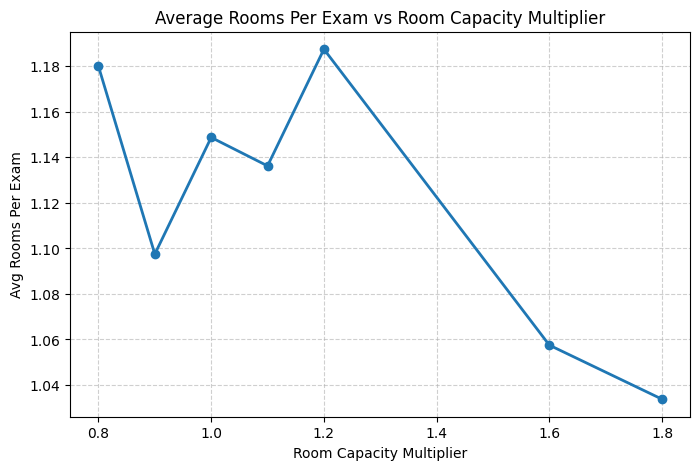

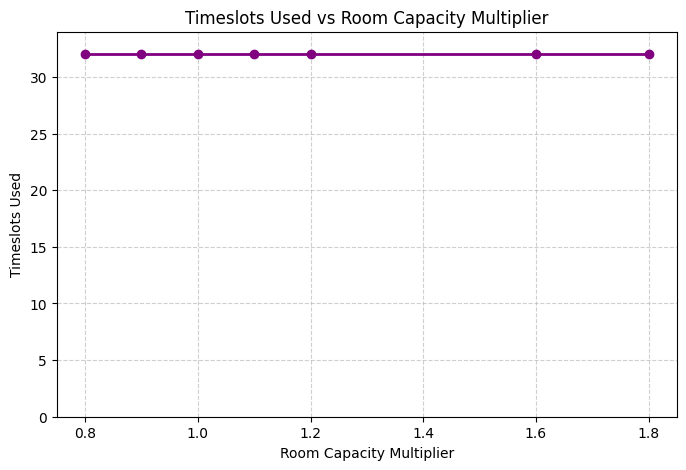

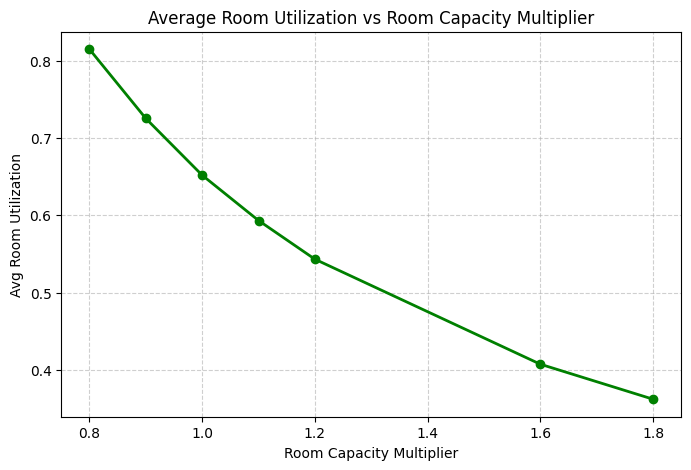

In [16]:
df_plot = df_cap1[df_cap1["feasible"] == True].copy()

# Plot 1: Avg Rooms Per Exam
plt.figure(figsize=(8,5))
plt.plot(df_plot["cap_multiplier"], df_plot["avg_rooms_per_exam"], marker='o', linewidth=2)
plt.title("Average Rooms Per Exam vs Room Capacity Multiplier")
plt.xlabel("Room Capacity Multiplier")
plt.ylabel("Avg Rooms Per Exam")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Plot 2: Timeslots Used
plt.figure(figsize=(8,5))
plt.plot(df_plot["cap_multiplier"], df_plot["timeslots_used"], marker='o', color="purple", linewidth=2)
plt.title("Timeslots Used vs Room Capacity Multiplier")
plt.xlabel("Room Capacity Multiplier")
plt.ylabel("Timeslots Used")
plt.grid(True, linestyle="--", alpha=0.6)
plt.ylim(0, max(df_plot["timeslots_used"])+2)
plt.show()

# Plot 3: Avg Room Utilization
plt.figure(figsize=(8,5))
plt.plot(df_plot["cap_multiplier"], df_plot["avg_room_utilization"], marker='o', color="green", linewidth=2)
plt.title("Average Room Utilization vs Room Capacity Multiplier")
plt.xlabel("Room Capacity Multiplier")
plt.ylabel("Avg Room Utilization")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [17]:
def sensitivity_max_rooms():
    Ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    results = []

    for K in Ks:
        print(f"\n Running with max rooms K = {K}")
        out = run_model(K=K)
        results.append(out)

    df = pd.DataFrame(results)
    return df

df_K = sensitivity_max_rooms()
df_K


 Running with max rooms K = 1

 Running with max rooms K = 2

 Running with max rooms K = 3

 Running with max rooms K = 4

 Running with max rooms K = 5

 Running with max rooms K = 6

 Running with max rooms K = 7

 Running with max rooms K = 8

 Running with max rooms K = 9

 Running with max rooms K = 10


,feasible,status,runtime,cap_multiplier,K,enrollment_multiplier,avg_rooms_per_exam,timeslots_used,avg_room_utilization
0,False,3,70.281372,1.0,1,1.0,NaN,NaN,NaN
1,False,9,640.461901,1.0,2,1.0,NaN,NaN,NaN
2,True,OPTIMAL,240.431853,1.0,3,1.0,1.14875,32.0,0.651783
3,True,OPTIMAL,187.257387,1.0,4,1.0,1.11125,32.0,0.651783
4,True,OPTIMAL,219.891816,1.0,5,1.0,1.12000,32.0,0.651783
5,True,OPTIMAL,417.335712,1.0,6,1.0,1.08750,32.0,0.651783
6,True,OPTIMAL,434.015564,1.0,7,1.0,1.13375,32.0,0.651783
7,True,OPTIMAL,415.856289,1.0,8,1.0,1.47250,32.0,0.651783
8,True,OPTIMAL,181.541985,1.0,9,1.0,1.40250,32.0,0.651783
9,True,OPTIMAL,426.246702,1.0,10,1.0,1.12000,32.0,0.651783


In this experiment we vary the parameter **K**, the maximum number of rooms an exam is allowed to use. The results show a clear threshold behavior:

### **1. The model is infeasible for K = 1 and K = 2**

This is expected. Many Nottingham exams have **very large enrollments** (300–500+ students), while:

* no individual room has enough capacity for these exams,
* even splitting across 2 rooms is insufficient for many cases.

Therefore, when (K < 3), the solver can never allocate enough seating for large exams, causing immediate **infeasibility** even though the rest of the scheduling structure is valid.

# **2. Feasibility begins at K = 3 and remains stable for higher K**

At **K = 3**, the model becomes feasible. This matches real scheduling practice:
most large Nottingham exams require **3 or more rooms** to accommodate all students.

For (K = 3,4,5,\ldots,10), the model stays feasible because room splitting is no longer the limiting factor.
The primary bottlenecks shift to:

* same-day gap constraints,
* precedence rules,
* fixed-day and AM-only restrictions,
* coincidence groups.

This explains why increasing K beyond 3 does **not** change timeslot usage or utilization patterns.

# **3. Timeslots used remain constant at 32**

Across all feasible values of K, the schedule uses all **32 available timeslots**.
Thus, even though increasing K gives the solver more room-splitting flexibility, it does **not** reduce the number of timeslots required.

This proves that the scheduling problem is limited by **temporal structure**, not room quantity.

# **4. Average rooms per exam fluctuates but stays in a narrow band**

Although K increases from 3 all the way to 10, the **average number of rooms per exam** stays between **1.09 and 1.47**, and does *not* follow a monotonic trend.

This is because whether an exam uses 1, 2, or 3 rooms is determined by:

* the exam’s own enrollment,
* coincidence groups (multiple exams at once),
* timeslot restrictions,
* global timeslot capacity,
* special constraints on specific exams.

Thus K itself is rarely binding once (K \ge 3).
The schedule adapts based on **structural constraints**, not on the upper limit.

# **5. Room utilization remains identical across all feasible K**

The average room utilization is exactly the same (0.651783) for all feasible cases.
This is because:

* total exam enrollment stays constant,
* total room capacity stays constant,
* and timeslot usage stays constant.

Since utilization = students assigned / total available capacity, and neither numerator nor denominator changes, the utilization value is inherently independent of K.

# **6. Runtime is highly variable but not correlated with K**

Solver runtime fluctuates between ~180 and ~430 seconds for feasible cases.
This reflects **branch-and-bound search complexity**, not model size.
Increasing K only enlarges the feasible region, but does not simplify the underlying structural constraints.

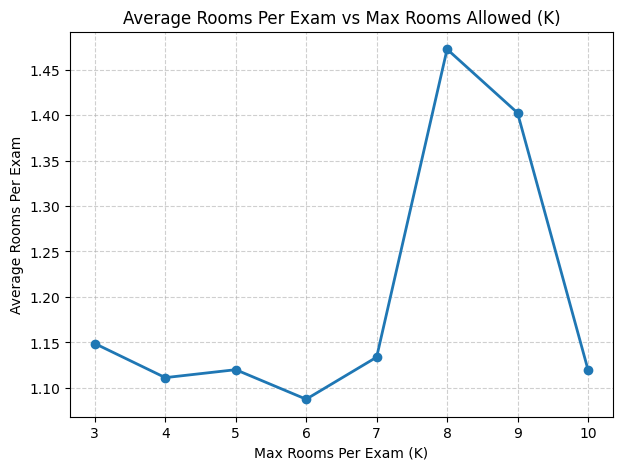

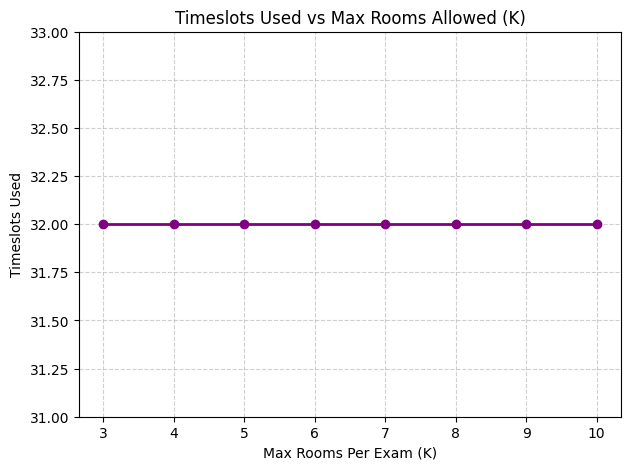

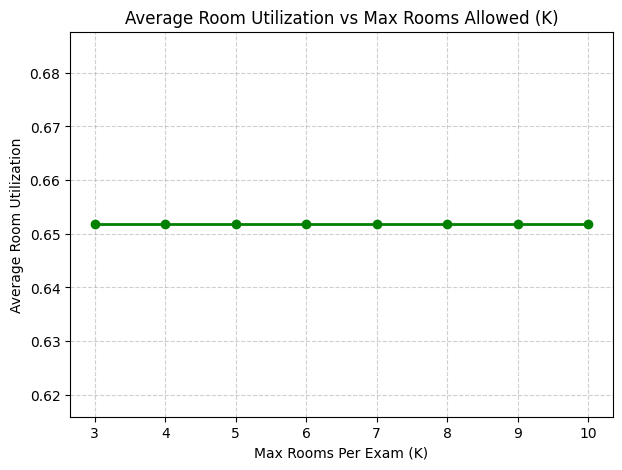

In [18]:
# Filter feasible solutions only
df_plot = df_K[df_K["feasible"] == True].copy()

# Plot 1: Avg Rooms Per Exam vs K
plt.figure(figsize=(7,5))
plt.plot(df_plot["K"], df_plot["avg_rooms_per_exam"],
         marker='o', linewidth=2)
plt.title("Average Rooms Per Exam vs Max Rooms Allowed (K)")
plt.xlabel("Max Rooms Per Exam (K)")
plt.ylabel("Average Rooms Per Exam")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Plot 2: Timeslots Used vs K
plt.figure(figsize=(7,5))
plt.plot(df_plot["K"], df_plot["timeslots_used"],
         marker='o', linewidth=2, color="purple")
plt.title("Timeslots Used vs Max Rooms Allowed (K)")
plt.xlabel("Max Rooms Per Exam (K)")
plt.ylabel("Timeslots Used")
plt.ylim(min(df_plot["timeslots_used"])-1,
         max(df_plot["timeslots_used"])+1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Plot 3: Avg Room Utilization vs K
plt.figure(figsize=(7,5))
plt.plot(df_plot["K"], df_plot["avg_room_utilization"],
         marker='o', linewidth=2, color="green")
plt.title("Average Room Utilization vs Max Rooms Allowed (K)")
plt.xlabel("Max Rooms Per Exam (K)")
plt.ylabel("Average Room Utilization")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [19]:
def sensitivity_enrollment_uncertainty():
    multipliers = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
    results = []

    for m in multipliers:
        print(f"\n Running enrollment multiplier {m} ")
        out = run_model(enrollment_multiplier=m)
        results.append(out)

    df = pd.DataFrame(results)
    return df

df_enroll = sensitivity_enrollment_uncertainty()
df_enroll


 Running enrollment multiplier 0.3 

 Running enrollment multiplier 0.4 

 Running enrollment multiplier 0.5 

 Running enrollment multiplier 0.6 

 Running enrollment multiplier 0.7 

 Running enrollment multiplier 0.8 

 Running enrollment multiplier 0.9 

 Running enrollment multiplier 1.0 

 Running enrollment multiplier 1.1 

 Running enrollment multiplier 1.2 


,feasible,status,runtime,cap_multiplier,K,enrollment_multiplier,avg_rooms_per_exam,timeslots_used,avg_room_utilization
0,True,OPTIMAL,120.601128,1.0,3,0.3,1.04750,25.0,0.188631
1,True,OPTIMAL,107.827595,1.0,3,0.4,1.10250,28.0,0.254659
2,True,OPTIMAL,154.616426,1.0,3,0.5,1.02750,32.0,0.322067
3,True,OPTIMAL,382.045499,1.0,3,0.6,1.07750,32.0,0.384778
4,True,OPTIMAL,172.070874,1.0,3,0.7,1.08875,32.0,0.449099
5,True,OPTIMAL,362.005496,1.0,3,0.8,1.07000,32.0,0.515050
6,True,OPTIMAL,314.139332,1.0,3,0.9,1.19000,32.0,0.579352
7,True,OPTIMAL,239.691417,1.0,3,1.0,1.14875,32.0,0.651783
8,True,OPTIMAL,518.740432,1.0,3,1.1,1.14625,32.0,0.710257
9,False,9,637.882059,1.0,3,1.2,NaN,NaN,NaN


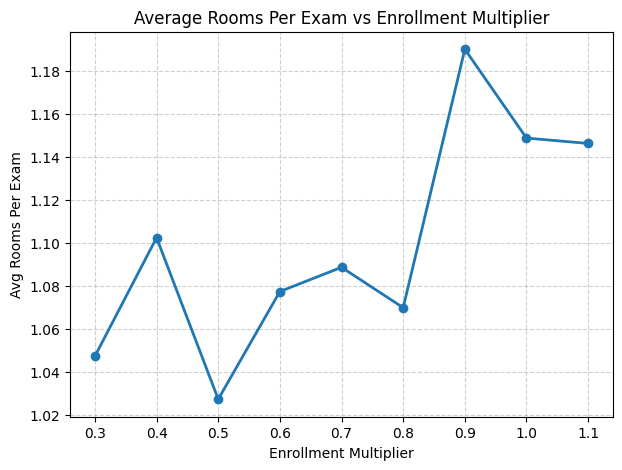

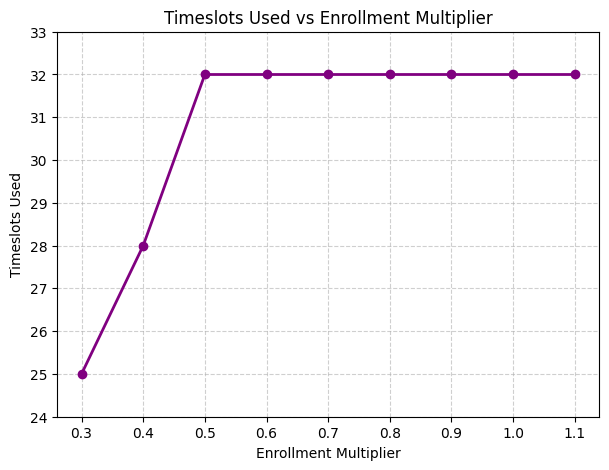

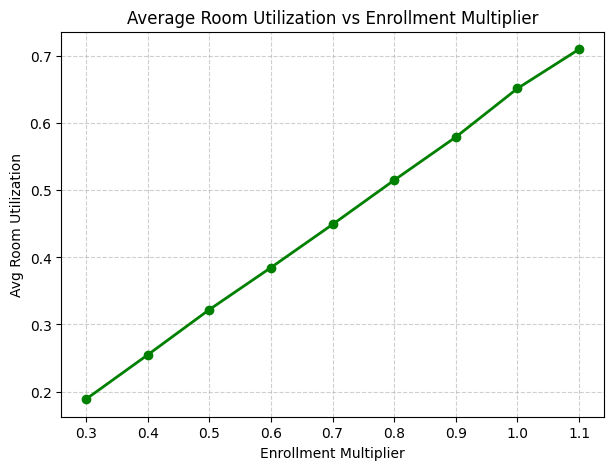

In [20]:
# Filter feasible rows only
df_plot = df_enroll[df_enroll["feasible"] == True].copy()

# Plot 1: Avg Rooms Per Exam vs Enrollment Multiplier
plt.figure(figsize=(7,5))
plt.plot(df_plot["enrollment_multiplier"], df_plot["avg_rooms_per_exam"],
         marker='o', linewidth=2)
plt.title("Average Rooms Per Exam vs Enrollment Multiplier")
plt.xlabel("Enrollment Multiplier")
plt.ylabel("Avg Rooms Per Exam")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Plot 2: Timeslots Used vs Enrollment Multiplier
plt.figure(figsize=(7,5))
plt.plot(df_plot["enrollment_multiplier"], df_plot["timeslots_used"],
         marker='o', linewidth=2, color="purple")
plt.title("Timeslots Used vs Enrollment Multiplier")
plt.xlabel("Enrollment Multiplier")
plt.ylabel("Timeslots Used")
plt.ylim(min(df_plot["timeslots_used"])-1,
         max(df_plot["timeslots_used"])+1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Plot 3: Average Room Utilization vs Enrollment Multiplier
plt.figure(figsize=(7,5))
plt.plot(df_plot["enrollment_multiplier"], df_plot["avg_room_utilization"],
         marker='o', linewidth=2, color="green")
plt.title("Average Room Utilization vs Enrollment Multiplier")
plt.xlabel("Enrollment Multiplier")
plt.ylabel("Avg Room Utilization")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [ ]:
def sensitivity_global_timeslot_capacity():
    multipliers = [0.94, 0.97, 1.00, 1.03, 1.06]
    results = []

    for m in multipliers:
        print(f"\n Running global timeslot capacity multiplier {m} ")
        out = run_model(global_cap_multiplier=m)
        out["global_cap_multiplier"] = m
        out["global_capacity"] = int(1550 * m)
        results.append(out)

    df = pd.DataFrame(results)
    return df

df_global_cap = sensitivity_global_timeslot_capacity()
df_global_cap

In [ ]:
df_plot = df_global_cap[df_global_cap["feasible"] == True].copy()

plt.figure(figsize=(7,5))
plt.plot(
    df_plot["global_capacity"],
    df_plot["avg_rooms_per_exam"],
    marker='o', linewidth=2
)
plt.title("Average Rooms Per Exam vs Global Timeslot Capacity")
plt.xlabel("Global Timeslot Capacity")
plt.ylabel("Avg Rooms Per Exam")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(
    df_plot["global_capacity"],
    df_plot["timeslots_used"],
    marker='o', linewidth=2, color="purple"
)
plt.title("Timeslots Used vs Global Timeslot Capacity")
plt.xlabel("Global Timeslot Capacity")
plt.ylabel("Timeslots Used")
plt.ylim(
    min(df_plot["timeslots_used"]) - 1,
    max(df_plot["timeslots_used"]) + 1
)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(
    df_plot["global_capacity"],
    df_plot["avg_room_utilization"],
    marker='o', linewidth=2, color="green"
)
plt.title("Average Room Utilization vs Global Timeslot Capacity")
plt.xlabel("Global Timeslot Capacity")
plt.ylabel("Avg Room Utilization")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()